### Advanced Lane Line 순서
1. 일련의 체스 판 이미지에 대해 카메라 보정 행렬과 왜곡 계수를 계산하기
2. 이미지에 왜곡 보정을 적용하기
3. 색상 변환, 그라디언트 등을 사용하여 임계 값 이진 이미지만들기
4. 원근 변환을 적용하여 이진 이미지를 수정하기( "조감도").
5. 차선 픽셀을 감지하고 차선 경계를 찾기
6. 중앙을 기준으로 차선의 곡률과 차량 위치를 결정하기
7. 감지 된 차선 경계를 원래 이미지로 다시 왜곡하기.
8. 차선 경계의 시각적 표시와 차선 곡률 및 차량 위치의 수치 추정 출력하기

In [46]:
#사용할것들 import하기
#1. python -m pip install opencv-python
#2. pip3 install moviepy 
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip  #영상을 실행시킬때 필요하다
from IPython.display import HTML

%matplotlib inline

print('...')  #실행이 됐는지 확인하기위해 출력하기

...


#### 1. 일련의 체스 판 이미지에 대해 카메라 보정 행렬과 왜곡 계수를 계산하기

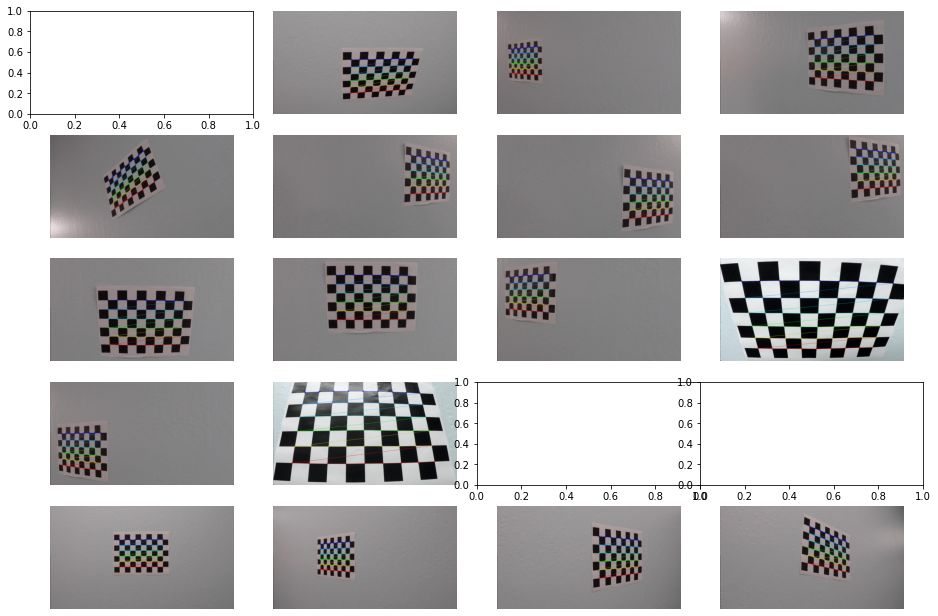

In [5]:
# 1. 먼저 체스판 이미지를 사용하여 카메라 보정을 계산하기.
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# 모든 이미지에서 객체 포인트와 이미지 포인트를 저장하는 배열설정하기
objpoints = [] # 3d 실제공간
imgpoints = [] # 2d 평면이미지

# calibraion할 이미지들
images = glob.glob('calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# 모든 이미지에서 객체 포인트와 이미지 포인트를 저장하는 배열
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # 체스 판 모서리 찾기
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)

        # 아래 사이트를 참고
        # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
    
        # 모서리를 그리고 표시해라
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)   #지정된 수의 체스 판 모서리를 찾을 수 없기 때문에 이러한 이미지 중 일부가 나타나지 않는다.


#### 2. 이미지에 왜곡 보정을 적용하기

...


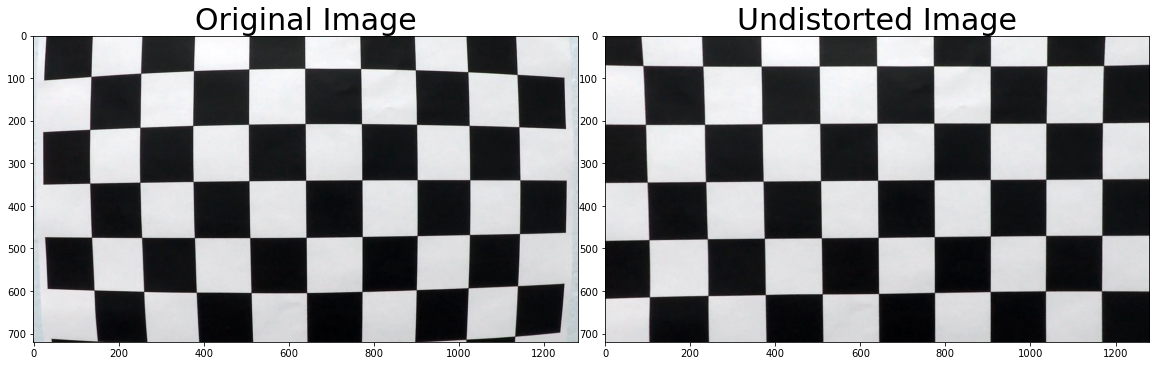

In [7]:
# 2.이미지 왜곡 제거 테스트
img = cv2.imread('calibration1.jpg')

img_size = (img.shape[1], img.shape[0])  #이미지를 못불러와도 Nonetype erorr가 뜬다.


# camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# 나중에 사용할 수 있도록 카메라 보정 결과를 저장한다
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

# 왜곡되지않은 이미지를 출력하기
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
print('...')

...


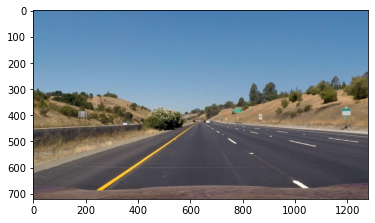

In [10]:
#예시) 원래 이미지
exampleImg = cv2.imread('straight_lines1.jpg')  #이미지를 읽어라
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)  #읽은 이미지를 RGB로 변환해라
plt.imshow(exampleImg)  #이미지 출력
print('...')

In [11]:
#왜곡되지않은 이미지
# 위에서 카메라 보정 매트릭스를 사용하여 이미지 왜곡 제거
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx) #OpenCV undistort () 함수를 사용하여 왜곡 제거
    return undist
print('...')

...


...


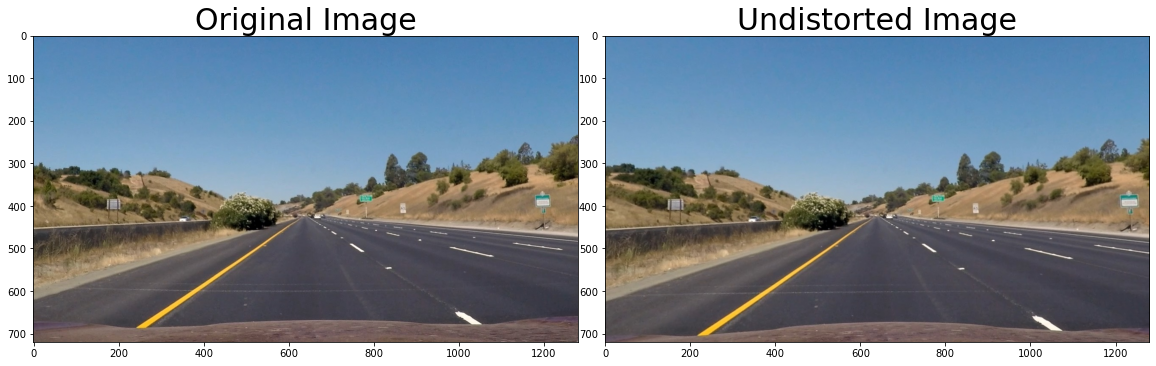

In [12]:
#왜곡되지않은 이미지 시각화하기
exampleImg_undistort = undistort(exampleImg)   #왜곡되지않은 이미지

# 왜곡되지않은것 출력하기
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(exampleImg_undistort)   #왜곡되지않은 이미지를 보여줘라
ax2.set_title('Undistorted Image', fontsize=30)

print('...')  #왜곡된건지 아닌지 차이는 자동차 후드를 보면 알수있다.

In [13]:
# 관점을 바꿔보자(앞->위)

def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # cv2.getPerspectiveTransform ()을 사용하여 변환 행렬 인 M과 역행렬 인 Minv를 가져온다.
    M = cv2.getPerspectiveTransform(src, dst) #src 및 dst 점이 주어지면 원근 변환 행렬을 계산한다.
    Minv = cv2.getPerspectiveTransform(dst, src)
    # cv2.warpPerspective ()를 사용하여 이미지를 조감도로 바꾼다
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv  #결과 이미지와 행렬 반환
print('...')

...


...


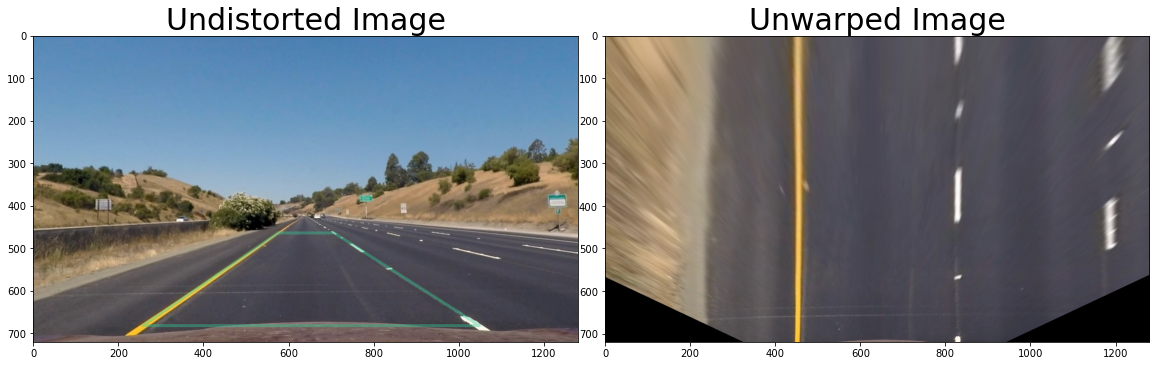

In [14]:
#관점변환한 것을 시각화해보자
h,w = exampleImg_undistort.shape[:2]

#변환을위한 소스 및 대상 지점 정의한다
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

exampleImg_unwarp, M, Minv = unwarp(exampleImg_undistort, src, dst)

# 조감도로 본 이미지 출력하기
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_unwarp)
ax2.set_title('Unwarped Image', fontsize=30)

print('...')

#### 3. 색상 변환, 그라디언트 등을 사용하여 임계 값 이진 이미지만들기

...


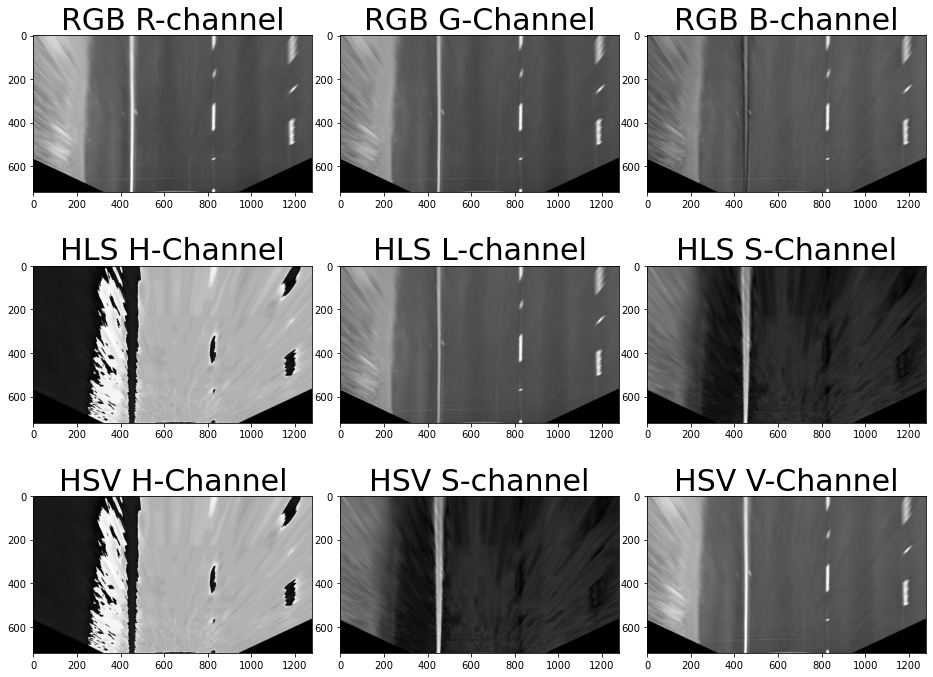

In [15]:
#여러 색공간채널을 사용해보자(RGB, HLS, HSV)
exampleImg_unwarp_R = exampleImg_unwarp[:,:,0]
exampleImg_unwarp_G = exampleImg_unwarp[:,:,1]
exampleImg_unwarp_B = exampleImg_unwarp[:,:,2]
exampleImg_unwarp_HLS = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2HLS)
exampleImg_unwarp_H = exampleImg_unwarp_HLS[:,:,0]
exampleImg_unwarp_L = exampleImg_unwarp_HLS[:,:,1]
exampleImg_unwarp_S = exampleImg_unwarp_HLS[:,:,2]
exampleImg_unwarp_HSV = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2HSV)
exampleImg_unwarp_H = exampleImg_unwarp_HSV[:,:,0]
exampleImg_unwarp_S = exampleImg_unwarp_HSV[:,:,1]
exampleImg_unwarp_V = exampleImg_unwarp_HSV[:,:,2]

fig, axs = plt.subplots(3,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()
axs[0].imshow(exampleImg_unwarp_R, cmap='gray')
axs[0].set_title('RGB R-channel', fontsize=30)
axs[1].imshow(exampleImg_unwarp_G, cmap='gray')
axs[1].set_title('RGB G-Channel', fontsize=30)
axs[2].imshow(exampleImg_unwarp_B, cmap='gray')
axs[2].set_title('RGB B-channel', fontsize=30)
axs[3].imshow(exampleImg_unwarp_H, cmap='gray')
axs[3].set_title('HLS H-Channel', fontsize=30)
axs[4].imshow(exampleImg_unwarp_L, cmap='gray')
axs[4].set_title('HLS L-channel', fontsize=30)
axs[5].imshow(exampleImg_unwarp_S, cmap='gray')
axs[5].set_title('HLS S-Channel', fontsize=30)
axs[6].imshow(exampleImg_unwarp_H, cmap='gray')
axs[6].set_title('HSV H-Channel', fontsize=30)
axs[7].imshow(exampleImg_unwarp_S, cmap='gray')
axs[7].set_title('HSV S-channel', fontsize=30)
axs[8].imshow(exampleImg_unwarp_V, cmap='gray')
axs[8].set_title('HSV V-Channel', fontsize=30)

print('...')

In [16]:
#소벨 절대 임계값, 차선을 색 변화도를 통해 검출한다.

# Sobel x 또는 y를 적용하는 함수를 정의하기
# 그런 다음 절대 값을 가져와 임계 값을 적용하기.
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # 1) grayscale로 변환하기
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    # 2) OpenCV Sobel () 함수로 x 또는 y 그라디언트를 적용하고 절대 값만들기
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 3) 8 비트 정수로 다시 크기 조정
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 4) 크키가 같은 행렬을 만들고 임계 값 적용
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 5) 이 마스크를 binary_output 이미지로 반환
    binary_output = sxbinary # Remove this line(이걸지우면 실행이 안되는데..)
    return binary_output
print('...')

...


In [17]:
#소벨을 위에서 구한 unwarped image에 적용시켜보자
def update(min_thresh, max_thresh):
    exampleImg_sobelAbs = abs_sobel_thresh(exampleImg_unwarp, 'x', min_thresh, max_thresh) #x축 gradient
    # 적용한 이미지 출력하기
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_sobelAbs, cmap='gray')
    ax2.set_title('Sobel Absolute', fontsize=30)

interact(update, 
         min_thresh=(20), 
         max_thresh=(100))

print('...')

interactive(children=(IntSlider(value=20, description='min_thresh', max=60, min=-20), IntSlider(value=100, des…

...


In [18]:
# 소벨 크기 임계값 이용하기
# 1) Sobel x 및 y를 적용하는 함수를 정의하기
# 2) gradient의 크기를 계산하기
# 3) 임계 값을 적용하기
def mag_thresh(img, sobel_kernel=25, mag_thresh=(25, 255)):
    
    # 1) grayscale로 변환하기
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Sobel x 및 y 그라디언트를 모두 사용
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) 크기 계산하기
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) 8 비트 (0-255)로 크기 조정하고 유형 = np.uint8로 변환
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) mag 임계 값이 충족되는 binary mask 만들기
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) 이 마스크를 binary_output 이미지로 반환하기
    binary_output = np.copy(sxbinary) 
    return binary_output
print('...')


...


In [19]:
def update(kernel_size, min_thresh, max_thresh):
    exampleImg_sobelMag = mag_thresh(exampleImg_unwarp, kernel_size, (min_thresh, max_thresh))
    # 소벨 크기 임계값 적용한 이미지 출력하기
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_sobelMag, cmap='gray')
    ax2.set_title('Sobel Magnitude', fontsize=30)

interact(update, kernel_size=(1,31,2), 
                 min_thresh=(27), 
                 max_thresh=(100))

print('...')

interactive(children=(IntSlider(value=15, description='kernel_size', max=31, min=1, step=2), IntSlider(value=2…

...


In [20]:
# 소벨 방향임계값 이용하기
# 1) Sobel x 및 y를 적용하는 함수를 정의하기
# 2) 그라디언트의 방향을 계산하기
# 3) 임계 값을 적용하기
def dir_thresh(img, sobel_kernel=7, thresh=(0, 0.09)):    

    # 1) grayscale로 전환하기
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Sobel x 및 y 그라디언트를 모두 사용
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) x 및 y 그라디언트의 절대 값으로 만들기
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) np.arctan2 (abs_sobely, abs_sobelx)를 사용하여 그라디언트의 방향을 계산하기
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) 방향 임계 값이 충족되는 이진 마스크 만들기
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) 이 마스크를 binary_output 이미지로 반환하기
    return binary_output  #여기는 왜 위에 코드랑 다르지..
print('...')

...


In [21]:
# 위의 함수를 실행시키기
def update(kernel_size, min_thresh, max_thresh):
    exampleImg_sobelDir = dir_thresh(exampleImg_unwarp, kernel_size, (min_thresh, max_thresh))
    # 소벨 방향임계값 적용한 이미지 출력하기
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_sobelDir, cmap='gray')
    ax2.set_title('Sobel Direction', fontsize=30)

interact(update, kernel_size=(1,31,2), 
                 min_thresh=(0), 
                 max_thresh=(0.05))  #결과를 보면 유독 차선만 진하게는 안되서 방향만으로 차선을 인식하기에 무리가 있는 것 같다.

print('...')

interactive(children=(IntSlider(value=15, description='kernel_size', max=31, min=1, step=2), IntSlider(value=0…

...


In [22]:
# 소벨 크기와 방향을 합쳐보자
def update(mag_kernel_size, mag_min_thresh, mag_max_thresh, dir_kernel_size, dir_min_thresh, dir_max_thresh):
    exampleImg_sobelMag2 = mag_thresh(exampleImg_unwarp, mag_kernel_size, (mag_min_thresh, mag_max_thresh))
    exampleImg_sobelDir2 = dir_thresh(exampleImg_unwarp, dir_kernel_size, (dir_min_thresh, dir_max_thresh))
    combined = np.zeros_like(exampleImg_sobelMag2)
    combined[((exampleImg_sobelMag2 == 1) & (exampleImg_sobelDir2 == 1))] = 1
    # 소벨 크기와 방향 합친거 출력하기
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Sobel Magnitude + Direction', fontsize=30)

interact(update, mag_kernel_size=(1,31,2), 
                 mag_min_thresh=(10), 
                 mag_max_thresh=(100),
                 dir_kernel_size=(1,31,2), 
                 dir_min_thresh=(0), 
                 dir_max_thresh=(0.05)) #결과를 통해 크기와 방향을 합치니까 차선이 선명하다는 것을 알수있다. 

print('...')  #엄청 깔끔해 진것을 볼수있다.

interactive(children=(IntSlider(value=15, description='mag_kernel_size', max=31, min=1, step=2), IntSlider(val…

...


In [23]:
# HLS S채널 임계값 이용하기
# HLS의 S- 채널 임계 값을 지정하는 함수 정의
def hls_sthresh(img, thresh=(125, 255)):
    # 1) HLS color 색공간으로 전환하기
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) S channel 임계값 적용하기
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    # 3) 임계 값 결과의 이진 이미지 반환
    return binary_output
print('...')

...


In [24]:
# 적용하기
def update(min_thresh, max_thresh):
    exampleImg_SThresh = hls_sthresh(exampleImg_unwarp, (min_thresh, max_thresh))
    # s-channel 임계값 적용한거 출력하기
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_SThresh, cmap='gray')
    ax2.set_title('HLS S-Channel', fontsize=30)

interact(update,
         min_thresh=(100), 
         max_thresh=(255))

print('...')

interactive(children=(IntSlider(value=100, description='min_thresh', max=300, min=-100), IntSlider(value=255, …

...


In [25]:
# HLS L채널 이용하기
# HLS의 L- 채널 임계 값을 지정하는 함수 정의
def hls_lthresh(img, thresh=(210, 255)):
    # 1) HLS color 색공간으로 전환하기
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) L channel 임계값 적용하기
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) 임계 값 결과의 이진 이미지 반환
    return binary_output
print('...')

...


In [26]:
def update(min_thresh, max_thresh):
    exampleImg_LThresh = hls_lthresh(exampleImg_unwarp, (min_thresh, max_thresh))
    # L-channel 임계값 적용한거 출력하기
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_LThresh, cmap='gray')
    ax2.set_title('HLS L-Channel', fontsize=30)

interact(update,
         min_thresh=(160), 
         max_thresh=(255))  #L채널이 S채널보다는 더 잘 인식한다.

print('...')

interactive(children=(IntSlider(value=160, description='min_thresh', max=480, min=-160), IntSlider(value=255, …

...


In [27]:
# 이미치 처리 파이프라인
# 이미지를 조감도로 바꾸고 gradient크기와 L채널을 이용하여 차선검출하기
def pipeline(img):
    # 왜곡되지 않은 이미지로 만들기
    img_undistort = undistort(img)
    
    # 관점 바꾸기
    img_unwarp, M, Minv = unwarp(img_undistort, src, dst)

    # Sobel Absolute (using default parameters)
    img_sobelAbs = abs_sobel_thresh(img_unwarp)

    # Sobel Magnitude (using default parameters)
    #img_sobelMag = mag_thresh(img_unwarp)
    
    # Sobel Direction (using default parameters)
    #img_sobelDir = dir_thresh(img_unwarp)
    
    # HLS S-channel Threshold (using default parameters)
    #img_SThresh = hls_sthresh(img_unwarp)

    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_lthresh(img_unwarp)

    
    # Sobel Absolute와 HLS L-channel합치기
    combined = np.zeros_like(img_LThresh)
    combined[(img_LThresh == 1) | (img_sobelAbs==1)] = 1  #여러가지 해본결과 절대값과 L채널을 합쳤을 때가 가장 나았다.
    return combined, Minv
    
print('...')

...


#### 4. 원근 변환을 적용하여 이진 이미지를 수정하기( "조감도").

...


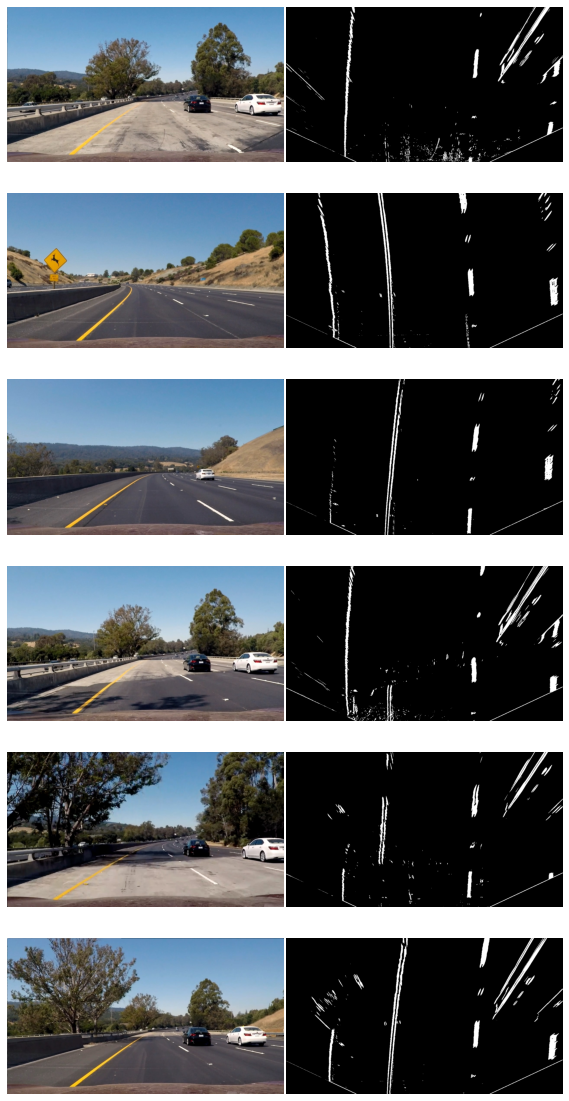

In [28]:
# 모든 이미지 파이프라인 실행하기
images = glob.glob('test*.jpg')  
                                          
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_bin, Minv = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

print('...')

#### 5. 차선 픽셀을 감지하고 차선 경계를 찾기

In [29]:
# sliding window하기
# 슬라이딩 윈도우를 사용하여 추출 된 선으로 다항식을 이진 영상에 맞추기
def sliding_window_polyfit(img):
    # 이미지의 아래쪽 절반에 대한 히스토그램을 가져오기
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # 히스토그램의 왼쪽과 오른쪽 절반의 피크 찾기(차선의 시작위치 찾기)
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    # sliding windows개수 정하기
    nwindows = 10
    # window 너비 +/- 여백(margin) 설정
    margin = 80
    # 최근 window에 발견 된 최소 픽셀 수 설정
    minpix = 40
    # 위의 window와 이미지 모양에 따라 window 높이 설정하기
    window_height = np.int(img.shape[0]/nwindows)
    # 이미지에서 0이 아닌 모든 픽셀의 x 및 y 위치 식별하기
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # nwindows의 각 창에 대해 나중에 업데이트 될 현재 위치
    leftx_current = leftx_base
    rightx_current = rightx_base

    # 왼쪽 및 오른쪽 레인 픽셀 인덱스를받을 빈 목록을 만든다.
    left_lane_inds = []
    right_lane_inds = []
    # 시각화를 위한 직사각형 데이터
    rectangle_data = []


    # window를 하나씩 통과한다.
    for window in range(nwindows):
        # x와 y (오른쪽과 왼쪽)의 window 경계 식별
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # 창 내에서 x 및 y에서 0이 아닌 픽셀 식별하기
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # 이 인덱스를 목록에 추가하기
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # minpix 픽셀보다 큰 경우 평균 위치에서 다음 창을 최근에 표시하기
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # 인덱스 배열을 연결하기
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # 왼쪽 및 오른쪽 선 픽셀 위치 추출하기
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # 2 차 다항식을 각각에 맞추기
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data
print('...')


...


...


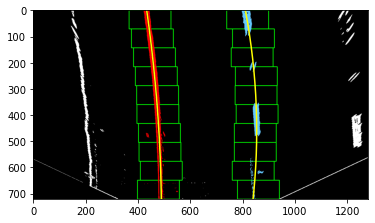

In [30]:
# 적용하기
# test이미지 결과 시각화하기
exampleImg = cv2.imread('test2.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin, Minv = pipeline(exampleImg)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

h = exampleImg.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

rectangles = visualization_data[0]
histogram = visualization_data[1]

# 결과를 시각화하고 시각화 할 출력 이미지를 만들기
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# plotting을위한 x 및 y 값 생성
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# 시각화 이미지에 windows 그리기
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# 이미지에서 0이 아닌 모든 픽셀의 x 및 y 위치 식별하기
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

print('...')

...


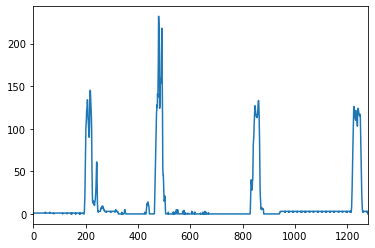

In [31]:
# 이미지에 대한 sliding window에서 histogram찾기
plt.plot(histogram)
plt.xlim(0,1280)
print('...')  #히스토그램을 1/4로 했기때문에 그래프위치가 높아도 인접한 두 선을 차선으로 인식할수있다.

In [35]:
# 이전프레임 이용한 polyfit
# 이전 fitting을 기반으로 이진 이미지에 다항식을 fitting하는 방법
# 한 비디오 프레임에서 다음 프레임으로 핏이 크게 변하지 않는다고 가정한다.
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # 다시, 왼쪽 및 오른쪽 라인 픽셀 위치를 추출
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds
print('...')

...


...


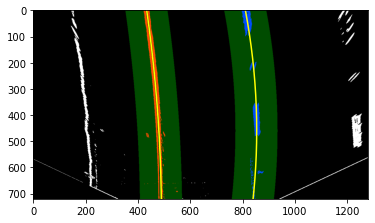

In [36]:
# 적용하기
# 예제 이미지에 결과 시각화
exampleImg2 = cv2.imread('test2.jpg')
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_bin, Minv = pipeline(exampleImg2)   
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# plotting을위한 x 및 y 값 생성
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# 그릴 이미지와 선택 창을 표시 할 이미지 만들기
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# 왼쪽 및 오른쪽 라인 픽셀의 색상
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# 검색 창 영역을 설명하는 다각형 생성
# 그리고 x 및 y 포인트를 cv2.fillPoly ()에 사용할 수있는 형식으로 다시 캐스팅
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# 뒤틀린 빈 이미지에 차선 그리기
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print('...')

#### 6. 중앙을 기준으로 차선의 곡률과 차량 위치를 결정하기

In [37]:
# 곡률 반경 및 차선 중심으로부터의 거리계산
# 곡률 반경과 차선 중심으로부터의 거리를 결정하는 방법
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # 픽셀 공간에서 미터로의 x 및 y 변환 정의
    ym_per_pix = 3.048/100 # y 차원에서 픽셀 당 미터, 차선은 10ft = 3.048m
    xm_per_pix = 3.7/378 # x 차원에서 픽셀 당 미터, 차선 너비는 12 피트 = 3.7m
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # 곡률 반경을 원하는 곳에 y 값을 정의하기
    # 이미지 하단에 해당하는 최대 y 값을 선택하기
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # 이미지에서 0이 아닌 모든 픽셀의 x 및 y 위치 식별
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # 다시, 왼쪽 및 오른쪽 라인 픽셀 위치를 추출합니다.
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # x, y에 새로운 다항식 맞추기
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # 새로운 곡률 반지름 계산하기
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # 이제 곡률 반경은 m(미터)
    
    # 중심으로부터의 거리는 이미지 x 중간 점-l_fit 및 r_fit 절편의 평균이다.
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist
print('...')

...


In [38]:
# 이미지에 적용하기
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 525.2863363752047 m, 232.75981484059207 m
Distance from lane center for example: -0.24210063283433975 m


#### 7. 감지 된 차선 경계를 원래 이미지로 다시 왜곡하기

In [39]:
# 감지된 차선을 원본 이미지에 다시 그리기
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # 선을 그릴 이미지 만들기
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # x 및 y 포인트를 cv2.fillPoly ()에 사용할 수있는 형식으로 다시 캐스팅
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # 뒤틀린 빈 이미지에 차선을 그립니다.
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # 역 perspective 행렬 (Minv)을 사용하여 공백을 다시 원래 이미지 공간으로 뒤틀기
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # 결과를 원본 이미지와 결합하기
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result
print('...')

...


...


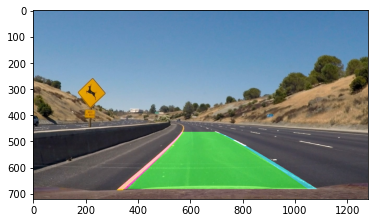

In [40]:
# 이미지에 적용하기
exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, Minv)
plt.imshow(exampleImg_out1)
print('...')

#### 8. 차선 경계의 시각적 표시와 차선 곡률 및 차량 위치의 수치 추정 출력하기

In [41]:
# 찾은 데이터(곡률반경, 거리)를 원본 이미지에 텍스트로 넣기
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img
print('...')

...


...


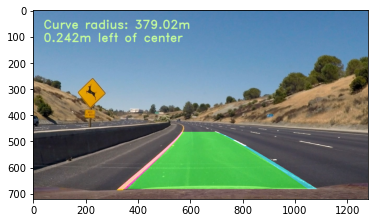

In [42]:
# 적용하기
exampleImg_out2 = draw_data(exampleImg_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(exampleImg_out2)
print('...')

In [43]:
# 데이터 저장을 위한 Line 클래스 만들기
# 각 라인 감지 특성을 수신 할 클래스 정의하기
class Line():
    def __init__(self):
        # 마지막 iteration에서의 선 감지여부
        self.detected = False  
        # 라인의 마지막 n 개 fitting의 x 값
        self.recent_xfitted = [] 
        #마지막 n 회 iterations에 대한 적합한 선의 평균 x 값
        self.bestx = None     
        #마지막 n 회 반복에 대해 평균화 된 다항식 계수
        self.best_fit = None  
        #가장 최근 fit에 대한 다항식 계수
        self.current_fit = []  
        #선의 곡률 반경
        self.radius_of_curvature = None 
        #라인에서 차량 중심까지의 거리 (미터)
        self.line_base_pos = None 
        #마지막 피팅과 새로운 피팅 간의 피팅 계수 차이
        self.diffs = np.array([0,0,0], dtype='float') 
        #감지 된 픽셀 수
        self.px_count = None
    def add_fit(self, fit, inds):
        if fit is not None:
            if self.best_fit is not None:
                # 우리가 가장 잘 맞는다면이 새로운 피팅이 어떻게 비교되는지보자
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # 오래된 핏을 버리고 최신 n을 유지하기
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # 또는 찾을 수없는 경우 기록에서 제거
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # 가장 오래된 핏을 버리기
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # 대기열에 여전히 적합한 항목이있는 경우 best_fit은 평균입니다.
                self.best_fit = np.average(self.current_fit, axis=0)
print('...')


...


In [44]:
# 완전한 이미지처리 파이프라인 만들기
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # 마지막 프레임에서 왼쪽과 오른쪽 선이 모두 감지되면 polyfit_using_prev_fit을 사용하고 그렇지 않으면 슬라이딩 창을 사용한다.
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # x 절편의 차이가 약 350 픽셀 (+/- 100 픽셀)이 아닌 경우 두 적합을 무효화하기
    if l_fit is not None and r_fit is not None:
        # 적합치에 대한 x 절편 (이미지 하단, x = 이미지 _ 높이) 계산
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # 존재하는 경우 current best fit 그리기
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # 멀티 뷰 출력을 합치기
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # 원본 출력 (왼쪽 상단)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # 이진 오버 헤드보기 (오른쪽 상단)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # 모든 fit이 추가 된 오버 헤드 (오른쪽 하단)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (왼쪽하단)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
           diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out
print('...')

...


In [45]:
# 이진 영상에 적합도를 그리자(얼마나 잘되는지)
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img
print('...')

...


In [50]:
# project video에 적용하기
l_line = Line()
r_line = Line()
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 4min 17s


In [51]:
# challenge video에 적용하기
l_line = Line()
r_line = Line()
video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')
processed_video = video_input2.fl_image(process_image)
%time processed_video.write_videofile(video_output2, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4
Wall time: 1min 34s


In [52]:
# harder challenge video
l_line = Line()
r_line = Line()
video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')
processed_video = video_input3.fl_image(process_image)
%time processed_video.write_videofile(video_output3, audio=False)

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video harder_challenge_video_output.mp4.
Moviepy - Writing video harder_challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready harder_challenge_video_output.mp4
Wall time: 5min 4s
